# Newsgroup Text Analysis Exercise

### Classification into 6 classes using F Chollets orginal model

This is a small exercise in text analysis following https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html.

Installing the NLTK corpora can be a little tricky for the uninitiated. After installing the library, you must use the downloader to download one or more text corpora. The downloader is part of the library. This utility has a GUI which tends to run fine on Windows and Linux. On Mac, it is a better bet to use the command-line version by calling download_shell(), e.g.

```bash
$ python
Python 3.7.6 (default, Jan  8 2020, 13:42:34)
[Clang 4.0.1 (tags/RELEASE_401/final)] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> import nltk
>>> nltk.download_shell()
```

For this exercise, it probably makes sense to download the 'popular' collection of corpora ('d popular'). At the very least, you'll need the stop words ('d stopwords'). You'll also need the [GloVe pre-trained word vectors](http://nlp.stanford.edu/data/glove.6B.zip) from Stanford (careful, it's and 822MB download!).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
import re

Using TensorFlow backend.


In [2]:
# Constants
MAX_NB_WORDS = 20000 ## most commonly occuring words in the dataset
MAX_SEQUENCE_LENGTH = 1000
#VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 100

In [3]:
# Read in some data
categories = ['soc.religion.christian', 'comp.graphics', 'sci.med', 'comp.windows.x', 'sci.space', 'alt.atheism']

#categories = ['alt.atheism',
# 'comp.graphics',
# 'comp.os.ms-windows.misc',
# 'comp.sys.ibm.pc.hardware',
# 'comp.sys.mac.hardware',
# 'comp.windows.x',
# 'misc.forsale',
# 'rec.autos',
# 'rec.motorcycles',
# 'rec.sport.baseball',
# 'rec.sport.hockey',
# 'sci.crypt',
# 'sci.electronics',
# 'sci.med',
# 'sci.space',
# 'soc.religion.christian',
# 'talk.politics.guns',
# 'talk.politics.mideast',
# 'talk.politics.misc',
# 'talk.religion.misc']

newsgroup_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
newsgroup_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))


In [4]:
print("%d documents" % len(newsgroup_train.filenames))
print("%d categories" % len(newsgroup_train.target_names))
print()

3443 documents
6 categories



In [5]:
# Print an example message
print(newsgroup_train["data"][1])

We have recently obtained a copy of color_xterm (from export.lcs.mit.edu) after
seeing it mentioned in a previous article. On compilation, it reports the
following undefined symbols:
	_get_wmShellWidgetClass
	_get_applicationShellWidgetClass

	but still runs. When sending escape sequences to set the colour,
any colour comes out as black text on a black background. Any Ideas?

Has anyone used this program in colour successfully?

Can anyone point me to any other colour terminal emulators?

We are running OpenWindows 3 on Sun Sparcs running SunOS 4.1.3.

				advaTHANKSnce  Ben Kelley.


## Optional: Pre-Processing

In [17]:
# Set up standard stop words
stop_words = set(stopwords.words('english')) 
print(stop_words)

{"mightn't", 'very', "wouldn't", 'below', 'out', 'then', 'after', 'all', 'this', 'over', 'y', "shan't", "won't", 'haven', 'we', "don't", 'just', 'him', 'her', "you'll", 'as', 'herself', 'between', 'which', 'shan', "hasn't", 'wouldn', 'll', 'for', 'won', 've', 'these', 'both', 'me', 'm', 't', 'its', 'any', 'other', "haven't", 'hasn', 'did', 'does', 'than', 'you', 'from', 'there', 'be', 'wasn', "hadn't", 'ours', 'the', 'didn', "you'd", 'd', "couldn't", 'myself', 'theirs', 'such', 'do', 'had', 'their', 'no', "wasn't", "isn't", 'about', 'up', "mustn't", 'not', 'an', 'with', 'to', 'while', 'before', 'shouldn', 'has', 'yours', 'ma', 'how', 'most', 'itself', 'doesn', 'needn', 's', 'they', 'should', 'again', 'same', 'where', "weren't", 'whom', 'against', 'those', 'aren', 'through', 'down', 'my', 'off', "you're", 'but', 'weren', 'himself', 'further', "shouldn't", "didn't", 'and', 'is', 'yourself', 'mightn', "you've", 'your', 'that', 'now', 'mustn', 'them', 'why', 'were', "it's", 'was', "needn't

In [27]:
# Put some additional words in the list
stop_words.update(['find','would','be','one','say','made','think','subject','see','fnal','articl','feel','given','led',
                  'view','way','either','however','yet','know','get','use','therefore','even','like','could'])

In [18]:
# Pre-processing

# Get rid of stop words e.g. with nltk (and stem)
ps = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+') ## Std pattern is '\w+|\$[\d\.]+|\S+'

newsgroup_trainN = []


for message in newsgroup_train.data:
    
    #r'[^A-Za-z0-9#]+'
    
    # Sub all the special characters (except _)
    document = re.sub(r'\W', ' ', message)
    document = re.sub(r'_', ' ', document)
    # Sub all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Sub single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Sub digits (https://stackoverflow.com/questions/39582859/python-regex-remove-numbers-and-numbers-with-punctaution?rq=1)
    document = re.sub(r'\b\d+(?:\.\d+)?\s+', ' ', document)
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Convert to Lowercase
    document = document.lower()
    document = document.strip()
    
    # Original code
    text_token = tokenizer.tokenize(document)
    messageN = ''
    
    for word in text_token:
        if word not in stop_words:
            #messageN = messageN + ' ' + ps.stem(word)
            # w/o stemming
            messageN = messageN + ' ' + word
            
    newsgroup_trainN.append(messageN)

newsgroup_train.data = newsgroup_trainN

# Print the same message as above, now in its processed form
print(newsgroup_train["data"][1])

 recently obtained copy color xterm export lcs mit edu seeing mentioned previous article compilation reports following undefined symbols get wmshellwidgetclass get applicationshellwidgetclass still runs sending escape sequences set colour colour comes black text black background ideas anyone used program colour successfully anyone point colour terminal emulators running openwindows sun sparcs running sunos advathanksnce ben kelley


## Tokenization

In [19]:
# Tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(newsgroup_train.data)

# Get size of vocabulary 
# 1 needs to be added because of resrver 0 index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

# Transforms each text in texts to a sequence of integers
X_train = tokenizer.texts_to_sequences(newsgroup_train.data)
X_test = tokenizer.texts_to_sequences(newsgroup_test.data)

print (X_train[0][:10])

Found 35942 unique tokens.
[11738, 292, 330, 1073, 179, 2857, 57, 3085, 9875, 2161]


In [20]:
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(newsgroup_train.target))
print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', labels.shape)

print (X_train[0][200:250])

Shape of data tensor: (3443, 1000)
Shape of label tensor: (3443, 6)
[  662   704   300  1172   364  1624   364  1596   161  9879  4812  5465
  4813   440   625    33 11745   952  6958    33  1929  2649   311    64
    57  3747   394    59    74     2    33    14   163  1735     1 11746
   833   220    95  1249  5842     3   222 14430  3204   403   361  6350
  7680   214]


In [21]:
# We don't need the full GloVe vocabulary, only the words we really need
# Helper function for creating the embedding matrix

def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


In [22]:
# Create the embedding matrix for our vocab
#num_words = min(MAX_NB_WORDS, vocab_size)
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt', tokenizer.word_index, EMBEDDING_DIM)

In [23]:
# Check how many of our words are covered by the GloVe vocab
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7691558622224696

In [12]:
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LENGTH, 
                           trainable=False))

## --> 74% accuracy w/ GloVe

model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))

model.add(layers.GlobalMaxPool1D())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         10537300  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)              

In [13]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 11314 samples, validate on 7532 samples
Epoch 1/10
11314/11314 [==============================] - 80s 7ms/sample - loss: 2.1313 - accuracy: 0.2758 - val_loss: 1.6949 - val_accuracy: 0.4222
Epoch 2/10
11314/11314 [==============================] - 79s 7ms/sample - loss: 1.3969 - accuracy: 0.5283 - val_loss: 1.4438 - val_accuracy: 0.5420
Epoch 3/10
11314/11314 [==============================] - 80s 7ms/sample - loss: 1.1096 - accuracy: 0.6254 - val_loss: 1.4434 - val_accuracy: 0.5607
Epoch 4/10
11314/11314 [==============================] - 92s 8ms/sample - loss: 0.9159 - accuracy: 0.6888 - val_loss: 1.5577 - val_accuracy: 0.5459
Epoch 5/10
11314/11314 [==============================] - 99s 9ms/sample - loss: 0.7509 - accuracy: 0.7405 - val_loss: 1.5952 - val_accuracy: 0.5720
Epoch 6/10
11314/11314 [==============================] - 94s 8ms/sample - loss: 0.6019 - accuracy: 0.7932 - val_loss: 1.7782 - val_accuracy: 0.5564
Epoch 7/10
11314/11314 [==============================] -

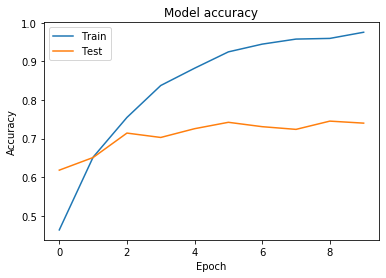

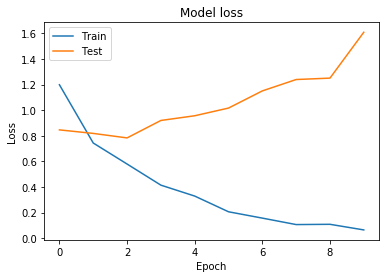

In [39]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Same model but w/o GloVe


In [40]:
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, 
                           input_length=MAX_SEQUENCE_LENGTH))

## --> 70% accuracy w/o GloVe


model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))

model.add(layers.GlobalMaxPool1D())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         4004900   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)              

In [41]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 3443 samples, validate on 2291 samples
Epoch 1/10
3443/3443 [==============================] - 47s 14ms/sample - loss: 1.5025 - accuracy: 0.3218 - val_loss: 1.2391 - val_accuracy: 0.4391
Epoch 2/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.9339 - accuracy: 0.5937 - val_loss: 1.0534 - val_accuracy: 0.5740
Epoch 3/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.5565 - accuracy: 0.7766 - val_loss: 1.1207 - val_accuracy: 0.6264
Epoch 4/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.3427 - accuracy: 0.8687 - val_loss: 1.2797 - val_accuracy: 0.6552
Epoch 5/10
3443/3443 [==============================] - 47s 14ms/sample - loss: 0.1945 - accuracy: 0.9306 - val_loss: 1.3693 - val_accuracy: 0.6792
Epoch 6/10
3443/3443 [==============================] - 47s 14ms/sample - loss: 0.0923 - accuracy: 0.9646 - val_loss: 1.7220 - val_accuracy: 0.6779
Epoch 7/10
3443/3443 [==============================] - 47s 14ms

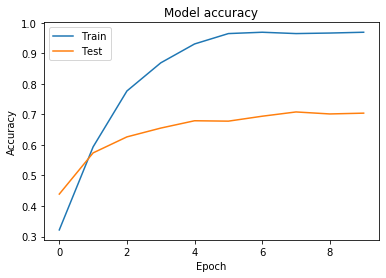

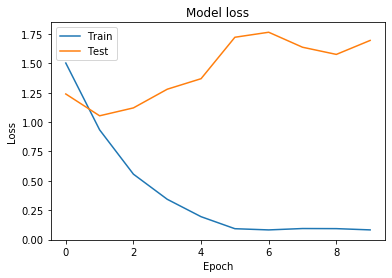

In [42]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Back to Michaels best model

In [24]:
# dropout

# another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D
# or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding.
# You can think of the pooling layers as a way to downsample (a way to reduce the size of)
# the incoming feature vectors

#embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LENGTH, 
                           trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         3594200   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 66        
Total params: 3,595,276
Trainable params: 1,076
Non-trainable params: 3,594,200
_________________________________________________________________


In [25]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/50
3443/3443 [==============================] - 2s 579us/sample - loss: 1.7679 - accuracy: 0.2001 - val_loss: 1.7209 - val_accuracy: 0.2807
Epoch 2/50
3443/3443 [==============================] - 2s 437us/sample - loss: 1.6950 - accuracy: 0.2881 - val_loss: 1.6429 - val_accuracy: 0.3470
Epoch 3/50
3443/3443 [==============================] - 2s 438us/sample - loss: 1.6152 - accuracy: 0.3294 - val_loss: 1.5616 - val_accuracy: 0.3715
Epoch 4/50
3443/3443 [==============================] - 2s 437us/sample - loss: 1.5487 - accuracy: 0.3477 - val_loss: 1.4980 - val_accuracy: 0.4116
Epoch 5/50
3443/3443 [==============================] - 2s 437us/sample - loss: 1.4938 - accuracy: 0.3674 - val_loss: 1.4405 - val_accuracy: 0.4208
Epoch 6/50
3443/3443 [==============================] - 2s 437us/sample - loss: 1.4133 - accuracy: 0.4069 - val_loss: 1.3547 - val_accuracy: 0.4579
Epoch 7/50
3443/3443 [==============================] - 2s 438us

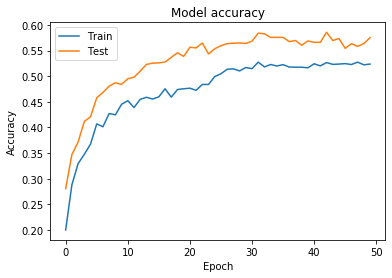

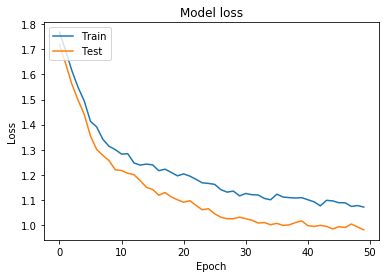

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()